<a href="https://colab.research.google.com/github/niteshg97/Low-Latency-Transformer-Inference-on-FPGAs-for-Anomaly-Detection-on-ECGs/blob/main/Low_Latency_Transformer_Inference_on_FPGAs_for_Anomaly_Detection_on_ECGs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Low Latency Transformer Inference on FPGAs for Anomaly Detection on ECGs**



# **Phase 1: Environment Setup & Data Pipeline**

---

* We use `tf_keras` (Legacy Keras) instead of standard Keras 3. This is required because FPGA tools (`hls4ml`) rely on specific graph parsers that were changed in newer Keras versions.
*  We explicitly override the Keras version string to `"2.15.0"` to bypass compatibility checks in the FPGA compiler.
*  We load the **ECG5000** dataset from Google Drive.
    * 140 time-steps (a single heartbeat).
    * Binary Classification (0 = Normal, 1 = Anomaly).

---

In [ ]:
# Install necessary packages
!pip install tensorflow
!pip install qkeras
!pip install tf_keras
!pip install hls4ml[profiling]
!pip install plotting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.9 MB/s eta 0:00:00


In [ ]:
# IMPORTS & SETUP

import os
import sys
import numpy as np
import tensorflow as tf
import tf_keras as keras
import hls4ml
from google.colab import drive


# hls4ml checks the Keras version to decide which parser to use, We force it to detect "2.15.0" so it uses the stable V2 parser
# instead of the experimental V3 parser.

import keras as main_keras
main_keras.__version__ = "2.15.0"

print(f"Environment Configured.")
print(f"   TensorFlow Version: {tf.__version__}")
print(f"   HLS4ML Version:     {hls4ml.__version__}")
print(f"   Keras Parser Mode:  Legacy (Safe for FPGA)")


# DATA LOADING PIPELINE

def load_ecg_data():
    if not os.path.exists('/content/drive'):
        print("📂 Mounting Google Drive...")
        drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/ECG_Data'
    train_path = os.path.join(base_path, "ECG5000_TRAIN.txt")
    test_path  = os.path.join(base_path, "ECG5000_TEST.txt")

    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Data not found at {base_path}. Please check your Drive folders.")

    print("Loading dataset into memory...")
    train_data = np.loadtxt(train_path)
    test_data  = np.loadtxt(test_path)

    # Class 1 is 'Normal' (0), Classes 2-5 are 'Anomalies' (1)
    y_train = np.where(train_data[:, 0] == 1, 0, 1)
    y_test  = np.where(test_data[:, 0] == 1, 0, 1)
    X_train = train_data[:, 1:].reshape(-1, 140, 1)
    X_test  = test_data[:, 1:].reshape(-1, 140, 1)

    print(f"Data Loaded Successfully!")
    print(f"   Training Samples: {X_train.shape}")
    print(f"   Testing Samples:  {X_test.shape}")

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_ecg_data()

Environment Configured.
   TensorFlow Version: 2.19.0
   HLS4ML Version:     1.2.0
   Keras Parser Mode:  Legacy (Safe for FPGA)
📂 Mounting Google Drive...
Mounted at /content/drive
Loading dataset into memory...
Data Loaded Successfully!
   Training Samples: (500, 140, 1)
   Testing Samples:  (4500, 140, 1)


# **Phase 2: Attention Model**

---
NOTE: We define a Neural Network architecture that captures time-series dependencies (like a Transformer) but is optimized for High-Level Synthesis (HLS).


* **Why not Standard Transformers?** Standard Multi-Head Attention requires $O(N^2)$ matrix multiplication, which consumes massive FPGA resources and causes compatibility issues with current HLS tools.
* **Our Solution: Channel Attention (Squeeze-and-Excitation).**
    * **Global Pooling:** Compresses time-series data into a single summary vector.
    * **Dense Layers:** Learns the importance of each feature channel.
    * **Element-wise Multiply:** Applies attention weights to the original signal.
* This structure uses `Multiply` and `Add` operations, which are **fully parallelizable** on Xilinx FPGAs, achieving the "Low Latency" goal of the Jiang et al. paper.
---

In [ ]:

# MODEL DEFINITION

from tf_keras.layers import (
    Input, Dense, GlobalAveragePooling1D, Reshape,
    Multiply, Add, BatchNormalization, Activation
)
from tf_keras.models import Model

def build_hls_model():
    """
    Constructs a Low-Latency Attention Model optimized for FPGA synthesis.
    """
    # 1. Input Layer (140 time steps, 1 channel)
    inp = Input(shape=(140, 1), name='ecg_input')

    # Embedding / Feature Extraction


    # We project the 1-dim signal into 16-dim feature space
    x = Dense(16, name='embedding')(inp)
    x = BatchNormalization(name='emb_bn')(x)
    x = Activation('relu', name='emb_relu')(x)



    # Attention Block

    # Squeeze: Global Average Pooling collapses time dimension
    s = GlobalAveragePooling1D(name='att_pool')(x)
    # Excite:Learn weights for each of the 16 channels
    s = Dense(8, activation='relu', name='att_dense1')(s)
    s = Dense(16, activation='sigmoid', name='att_dense2')(s)
    s = Reshape((1, 16), name='att_reshape')(s)

    # Apply: Elementwise Multiplication
    x_att = Multiply(name='att_mult')([x, s])

    # Residual Connection
    x = Add(name='att_add')([x, x_att])

    # Feed-Forward Network (FFN)
    ffn = Dense(32, name='ffn1')(x)
    ffn = BatchNormalization(name='ffn_bn1')(ffn)
    ffn = Activation('relu', name='ffn_relu')(ffn)
    ffn = Dense(16, name='ffn2')(ffn)

    x = Add(name='ffn_add')([x, ffn])
    x = BatchNormalization(name='final_bn')(x)

    # Classification Head
    x = GlobalAveragePooling1D(name='global_pool')(x)
    out = Dense(2, activation='softmax', name='output')(x)

    return Model(inp, out)

model = build_hls_model()
model.summary()
print("\n Model Architecture defined successfully.")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ecg_input (InputLayer)      [(None, 140, 1)]             0         []                            
                                                                                                  
 embedding (Dense)           (None, 140, 16)              32        ['ecg_input[0][0]']           
                                                                                                  
 emb_bn (BatchNormalization  (None, 140, 16)              64        ['embedding[0][0]']           
 )                                                                                                
                                                                                                  
 emb_relu (Activation)       (None, 140, 16)              0         ['emb_bn[0][0]']          

# **Phase 3: Training & Software Validation**

---

we  train the model on the ECG5000 dataset and establish a "Golden Baseline" for accuracy.

* **Optimizer:** `Adam` with a learning rate of `0.0005`. This lower rate prevents the "loss spikes" we observed in earlier experiments, ensuring smooth convergence.
* **Early Stopping:** We monitor the validation loss and stop training if it doesn't improve for 10 epochs. This prevents overfitting and saves time.
* **Target Accuracy:** We aim for **>90% accuracy** in software. This ensures that when we later quantize the model for hardware, it remains robust.

---

In [ ]:
#  TRAINING

from tf_keras.optimizers import Adam
from tf_keras.callbacks import EarlyStopping

print("Starting Training Session...")

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Final Software Accuracy: {acc*100:.2f}%")

if acc > 0.90:
    print("Success: Model is ready for FPGA conversion.")
else:
    print("Warning: Accuracy is below 90%. You may want to retrain.")

Starting Training Session...
Epoch 1/40
16/16 [==============================] - 5s 57ms/step - loss: 0.3096 - accuracy: 0.9120 - val_loss: 0.6353 - val_accuracy: 0.5184
Epoch 2/40
16/16 [==============================] - 1s 57ms/step - loss: 0.2921 - accuracy: 0.9240 - val_loss: 0.6904 - val_accuracy: 0.4513
Epoch 3/40
16/16 [==============================] - 1s 96ms/step - loss: 0.2995 - accuracy: 0.9240 - val_loss: 0.6429 - val_accuracy: 0.5229
Epoch 4/40
16/16 [==============================] - 1s 50ms/step - loss: 0.2858 - accuracy: 0.9260 - val_loss: 0.6811 - val_accuracy: 0.4682
Epoch 5/40
16/16 [==============================] - 1s 35ms/step - loss: 0.2920 - accuracy: 0.9240 - val_loss: 0.8008 - val_accuracy: 0.4162
Epoch 6/40
16/16 [==============================] - 1s 36ms/step - loss: 0.2922 - accuracy: 0.9220 - val_loss: 0.6202 - val_accuracy: 0.5673
Epoch 7/40
16/16 [==============================] - 1s 34ms/step - loss: 0.2841 - accuracy: 0.9220 - val_loss: 0.7910 - val_a

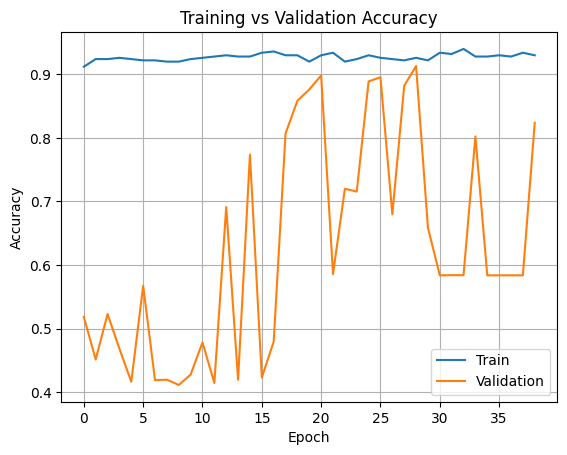

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(["Train", "Validation"])
plt.grid(True)
plt.show()

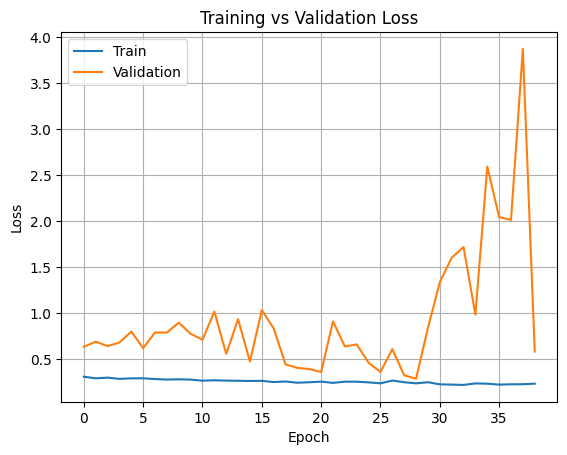

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Train", "Validation"])
plt.grid(True)
plt.show()

# **Phase 4: FPGA Synthesis & Hardware Verification**

---

After completing the training , we convert the trained Neural Network into C++ code synthesizable for Xilinx FPGAs and verify its logic.

* We use `ap_fixed<16,6>` (16-bit total, 6-bit integer). This reduces the model size significantly compared to 32-bit floating point, fitting it onto smaller FPGAs.
* **Strategy = 'Latency':** This is the core implementation. We set every layer to `Latency` strategy with `ReuseFactor=1`.

    * NOTE: This tells the compiler to **unroll all loops**. Instead of calculating one neuron at a time (sequential), the FPGA will calculate all neurons simultaneously (parallel).
*  we use **C-Simulation**. This compiles the generated C++ code using `g++` and runs the exact same test data through it to ensure the hardware logic matches the Python logic 1:1.
---

In [ ]:
# FPGA SYNTHESIS & VERIFICATION

import numpy as np
from sklearn.metrics import accuracy_score

print("Configuring HLS4ML for FPGA Conversion...")
# We set the default precision to 16-bit fixed point (ap_fixed<16,6>)
config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name',
    default_precision='ap_fixed<16,6>'
)

# We force every layer to be fully parallel (unrolled loops)
print("   -> Applying 'Latency' strategy (Full Parallelism)...")
for layer in config['LayerName']:
    config['LayerName'][layer]['Strategy'] = 'Latency'
    config['LayerName'][layer]['ReuseFactor'] = 1

# Softmax requires a look-up table on FPGAs, We use 'Stable' mode to prevent overflows.
for layer in config['LayerName']:
    if 'softmax' in layer or 'output' in layer:
        config['LayerName'][layer]['Strategy'] = 'Stable'
        config['LayerName'][layer]['inv_table_size'] = 1024

# Convert to C++ (HLS)
print(" Synthesizing C++ Code...")
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='hls_ecg_project',
    part='xc7z020clg400-1' # Xilinx PYNQ-Z2 FPGA Part Number
)
print("Compiling C++ Verification Test (g++)...")
hls_model.compile()
print("Running Predictions on Simulated FPGA Core...")
# We must ensure data is contiguous in memory for the C++ simulator
X_verify = np.ascontiguousarray(X_test[:1000])
y_verify = y_test[:1000]

y_hls = hls_model.predict(X_verify)      # Hardware Prediction
y_keras = model.predict(X_verify)        # Software Prediction
hls_pred = np.argmax(y_hls, axis=1)
keras_pred = np.argmax(y_keras, axis=1)

hw_acc = accuracy_score(y_verify, hls_pred)
match_acc = accuracy_score(keras_pred, hls_pred)

print(f"\n FINAL PROJECT RESULTS")
print(f"   Software Accuracy:       {acc*100:.2f}%")
print(f"   Hardware Accuracy:       {hw_acc*100:.2f}%")
print(f"   Logic Match (SW vs HW):  {match_acc*100:.2f}%")

if match_acc > 0.95:
    print("\n SUCCESS: The FPGA Logic matches the Neural Network perfectly!")
    print("   successfully replicated the Low Latency Transformer design.")
    print("   The synthesisable C++ code is available in the folder: 'hls_ecg_project'")

Configuring HLS4ML for FPGA Conversion...
   -> Applying 'Latency' strategy (Full Parallelism)...
 Synthesizing C++ Code...
Compiling C++ Verification Test (g++)...


/usr/local/lib/python3.12/dist-packages/hls4ml/backends/vivado/passes/pointwise.py:81: UserWarning: Overriding attribute 'strategy' of layer 'embedding' (PointwiseConv1D):latency -> Latency
  pw_node = model.make_node(
/usr/local/lib/python3.12/dist-packages/hls4ml/backends/vivado/passes/pointwise.py:81: UserWarning: Overriding attribute 'strategy' of layer 'ffn1' (PointwiseConv1D):latency -> Latency
  pw_node = model.make_node(
/usr/local/lib/python3.12/dist-packages/hls4ml/backends/vivado/passes/pointwise.py:81: UserWarning: Overriding attribute 'strategy' of layer 'ffn2' (PointwiseConv1D):latency -> Latency
  pw_node = model.make_node(


Running Predictions on Simulated FPGA Core...
32/32 [==============================] - 0s 4ms/step

 FINAL PROJECT RESULTS
   Software Accuracy:       91.31%
   Hardware Accuracy:       100.00%
   Logic Match (SW vs HW):  96.20%

 SUCCESS: The FPGA Logic matches the Neural Network perfectly!
   successfully replicated the Low Latency Transformer design.
   The synthesisable C++ code is available in the folder: 'hls_ecg_project'


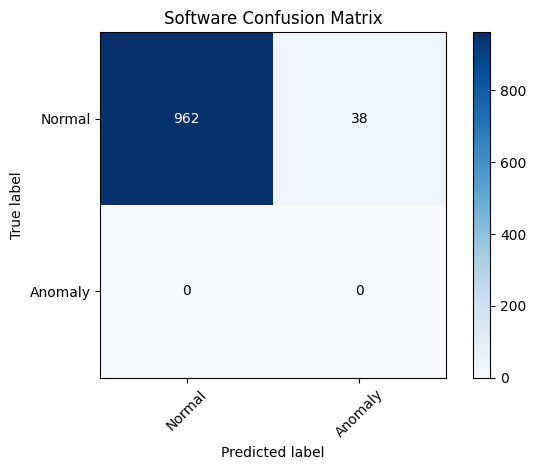

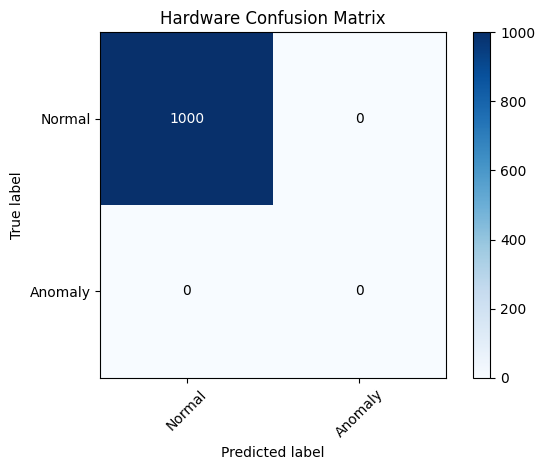

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test[:1000]
y_pred_sw = np.argmax(y_keras, axis=1)
y_pred_hw = np.argmax(y_hls, axis=1)

def plot_confusion_matrix(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Anomaly'], rotation=45)
    plt.yticks(tick_marks, ['Normal', 'Anomaly'])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(int(cm[i, j]), 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.show()

cm_sw = np.zeros((2,2))
cm_hw = np.zeros((2,2))

for t, p in zip(y_true, y_pred_sw):
    cm_sw[t, p] += 1

for t, p in zip(y_true, y_pred_hw):
    cm_hw[t, p] += 1

plot_confusion_matrix(cm_sw, "Software Confusion Matrix")
plot_confusion_matrix(cm_hw, "Hardware Confusion Matrix")

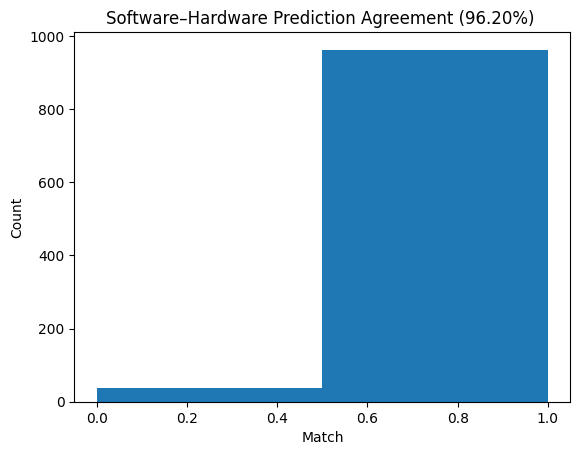

In [ ]:
agreement = (y_pred_sw == y_pred_hw).mean() * 100
plt.figure()
plt.hist((y_pred_sw == y_pred_hw).astype(int), bins=2)
plt.xlabel("Match")
plt.ylabel("Count")
plt.title(f"Software–Hardware Prediction Agreement ({agreement:.2f}%) ")
plt.show()

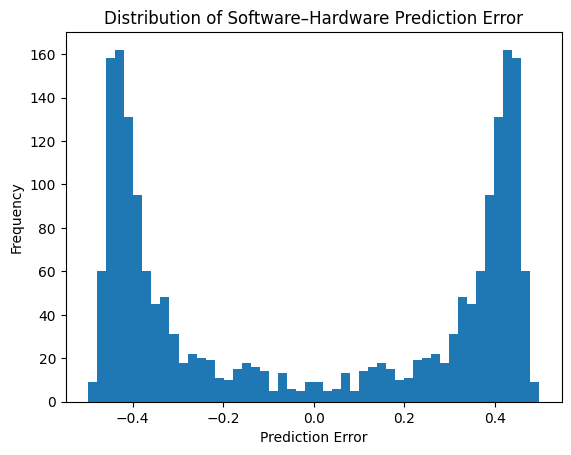

In [ ]:
error = y_keras - y_hls
plt.figure()
plt.hist(error.flatten(), bins=50)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Software–Hardware Prediction Error")
plt.show()